<a href="https://colab.research.google.com/github/roshancharlie/TATA-Motors-Close-Price-Forecasting/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import plotly
import cufflinks as cf
cf.go_offline()
import warnings
warnings.filterwarnings('ignore')


from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [30]:
start_date = '2020-01-01'
end_date = '2023-08-02'
ticker = 'TATAMOTORS.NS'
data = yf.download(ticker, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,185.149994,186.699997,183.600006,184.449997,183.876907,25968357
2020-01-02,185.000000,194.699997,184.600006,193.750000,193.148010,57289863
2020-01-03,192.899994,195.649994,189.250000,191.100006,190.506256,47572728
2020-01-06,191.000000,191.000000,185.050003,185.649994,185.073181,28621212
2020-01-07,187.000000,189.399994,182.300003,184.699997,184.126129,34995035


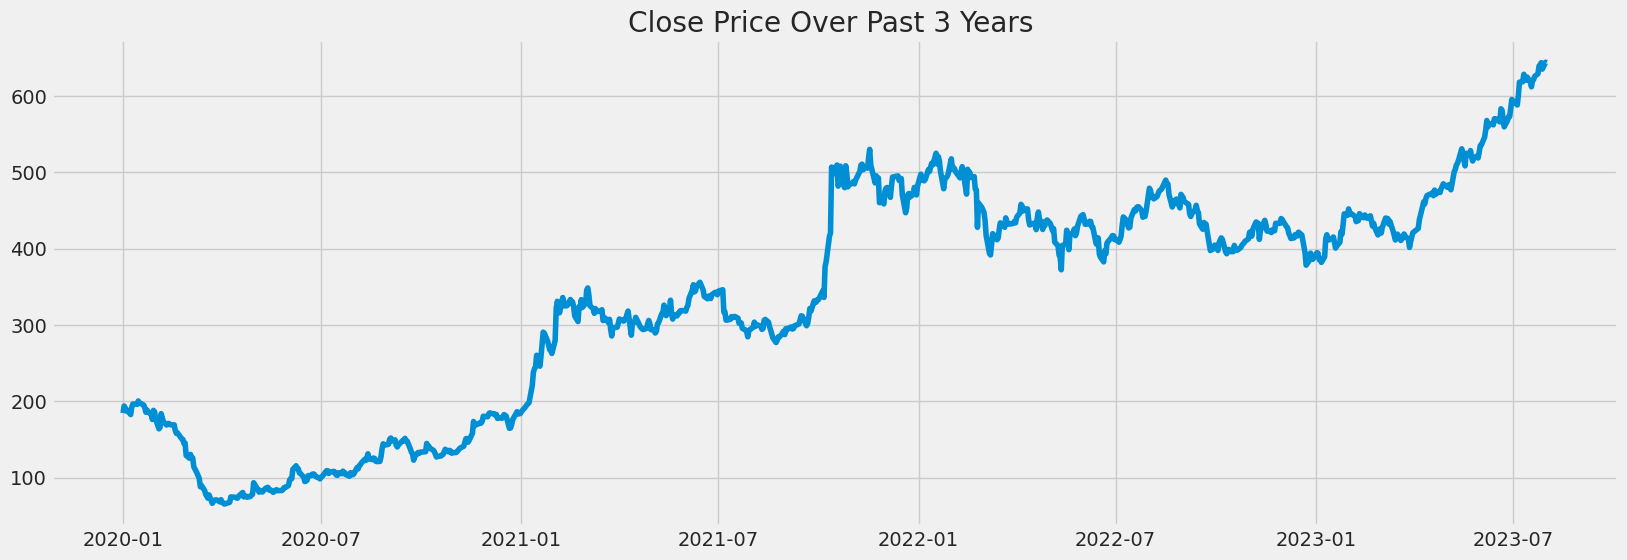

In [31]:
plt.figure(figsize=(18, 6))
plt.plot(data['Close'])
plt.title('Close Price Over Past 3 Years ')
plt.grid(True)
plt.show()


In [33]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

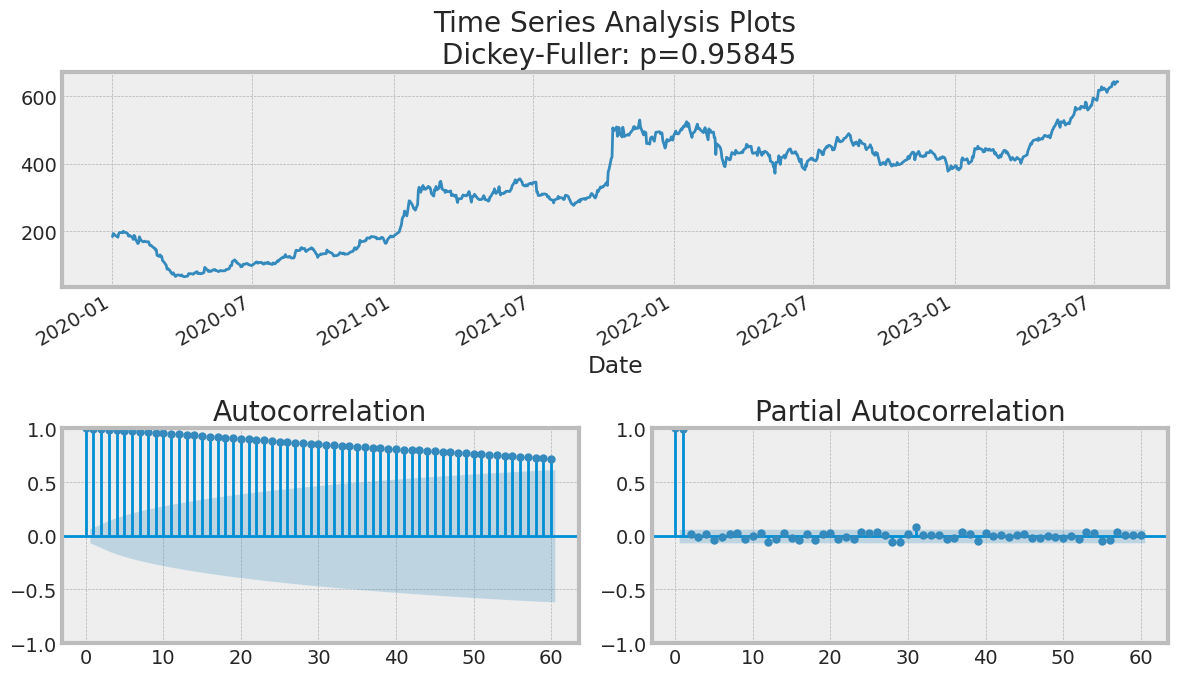

In [34]:
tsplot(data['Close'], lags=60)

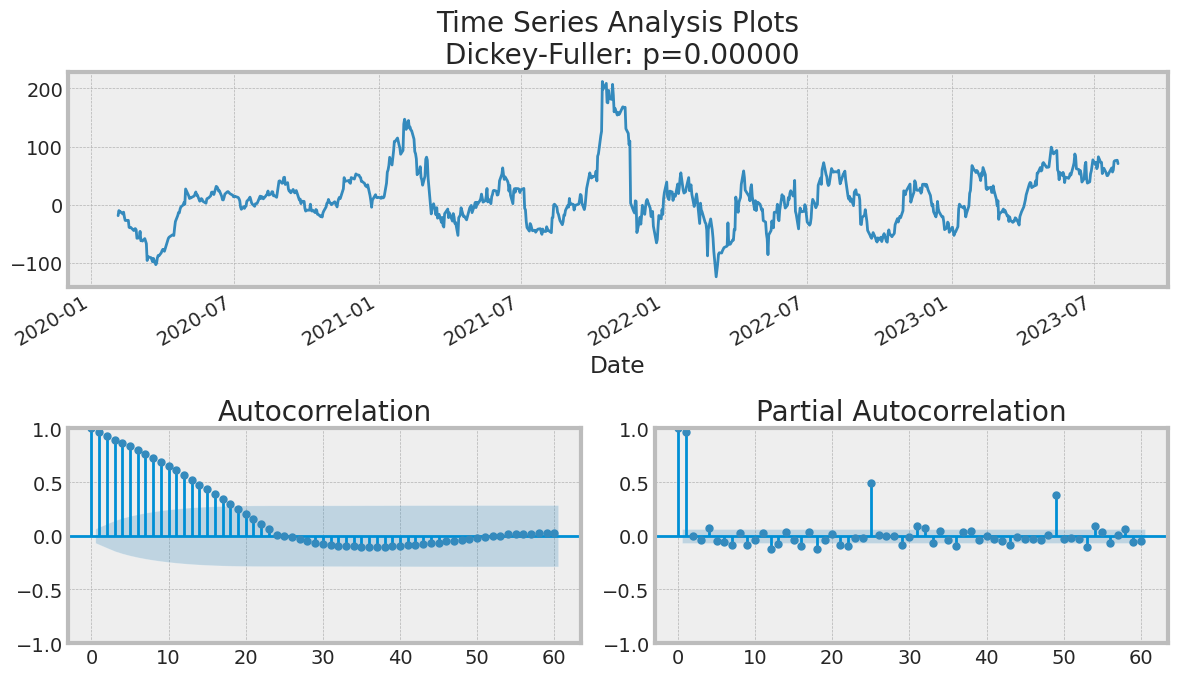

In [35]:
close_diff = data['Close'] - data['Close'].shift(24)
tsplot(close_diff[24:], lags=60)

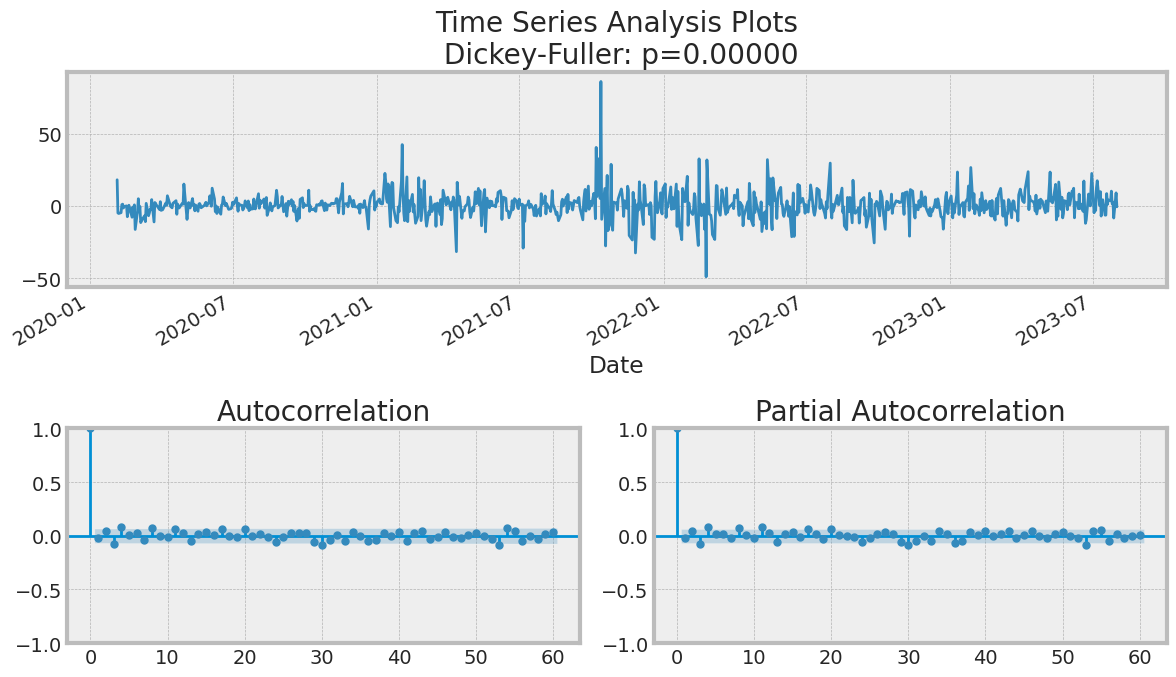

In [36]:
close_diff = data['Close'] - data['Close'].shift(1)
tsplot(close_diff[24+1:], lags=60)

In [37]:

# setting initial values and some bounds for them
ps = range(2, 5)
d=1
qs = range(2, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [38]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC

        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [40]:
result_table = optimizeSARIMA(data['Close'], parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

In [42]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(data['Close'], order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  891
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -3150.346
Date:                              Thu, 03 Aug 2023   AIC                           6318.691
Time:                                      07:42:10   BIC                           6361.566
Sample:                                           0   HQIC                          6335.100
                                              - 891                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4923      0.084    -17.824      0.000      -1.656      -1.328
ar.L2         -1.40

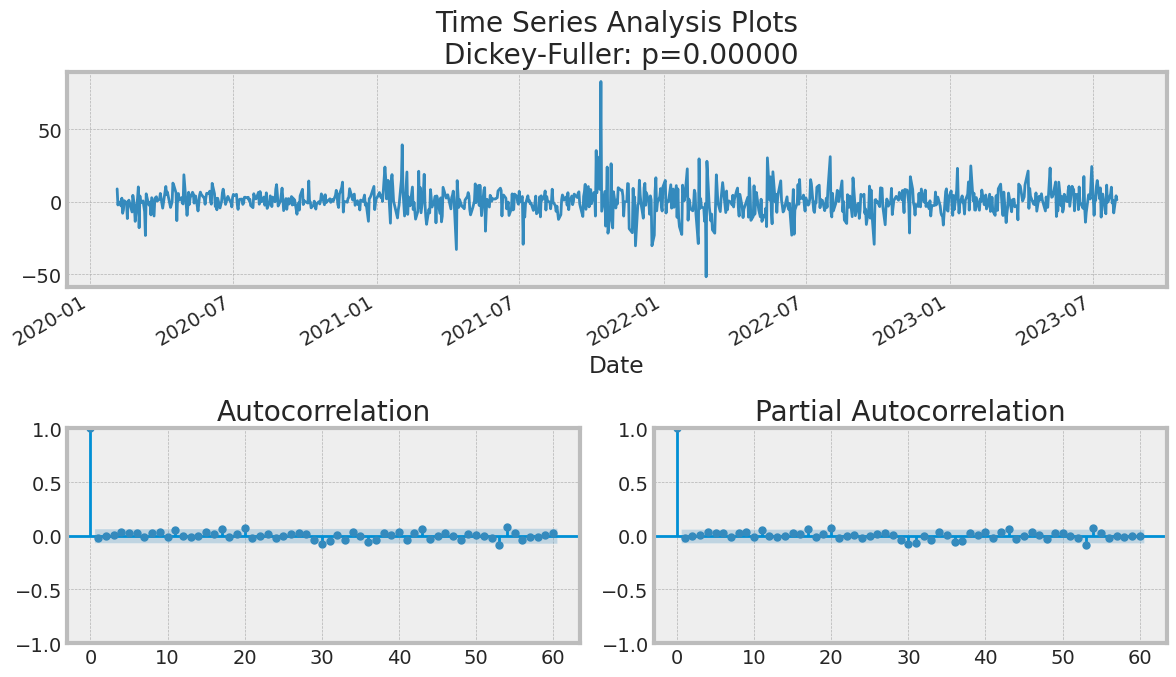

In [43]:
tsplot(best_model.resid[24+1:], lags=60)

In [84]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    p, d, q = model.model.order
    P, D, Q, s = model.model.seasonal_order

    # Adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    data['sarima_model'][:s+d] = np.NaN

    # Forecasting on n_steps forward
    forecast = model.get_forecast(steps=n_steps)
    forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(days=1), periods=n_steps)
    forecast = pd.Series(forecast.predicted_mean.values, index=forecast_index)
    forecast = data['sarima_model'].append(forecast)

    # Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

In [85]:
close = data[['Close']].copy()
close.rename(columns={'Close': 'actual'}, inplace=True)
close

,actual
Date,
2020-01-01,184.449997
2020-01-02,193.750000
2020-01-03,191.100006
2020-01-06,185.649994
2020-01-07,184.699997
...,...
2023-07-26,641.099976
2023-07-27,643.700012
2023-07-28,635.299988


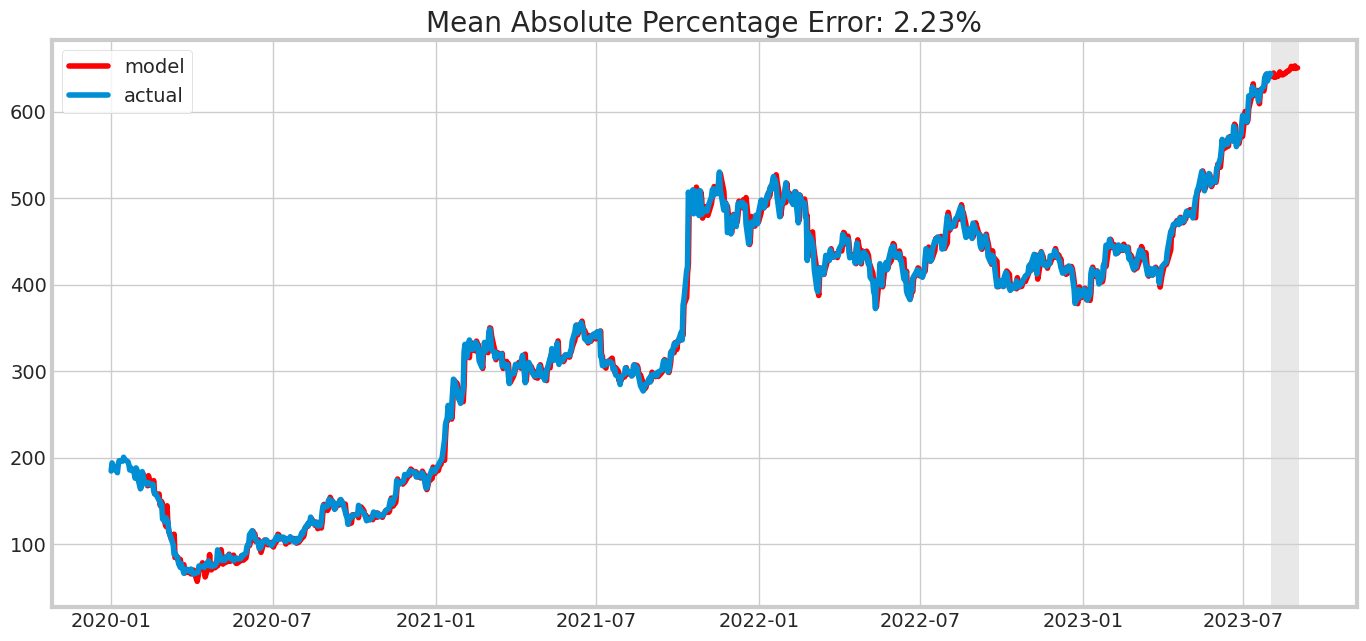

In [86]:
plotSARIMA(close, best_model, 30)